# Look what the KATS dragged in ! 

I wonder how this album would sell in Ecuadorian stores, it sure has the perfect cover :

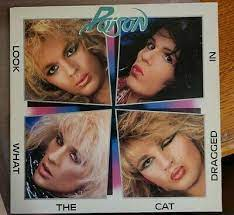

Anyway, the point of the pun in the title is that we are gonna be trying to use **one of the newest TimeSeries libraries** : [Kats from Facebook](https://facebookresearch.github.io/Kats/)

Kats has many functionnalities such as *anomaly detection*, *forecast*, or *automatic time series feature extraction* (hello [tsfresh](https://tsfresh.readthedocs.io/en/latest/), there's a new kid on the block)

It may serve as a multi purpose tool box wrapping a lot of classical (ARIMA, SARIMA) as well as SOTA methods (Prophet, LSTM) for Time series modelling, especially *forecasting*

In this notebook we use **Kats** to fit/predict one Prophet model per store/category and then ensemble the results with a more classic [LightGBM model tuned with Optuna](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTuner.html)



## Initialization

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas_profiling as pp

In [ ]:
from pathlib import Path 
path = Path('/kaggle/input/store-sales-time-series-forecasting/')

In [ ]:
!pip install kats

In [ ]:
df_train = pd.read_csv(path / 'train.csv', parse_dates=['date'], infer_datetime_format=True)
df_train.shape

In [ ]:
#Remove data close to earthquake , keep fresher data with a year at leat 
#df_train = df_train[df_train['date'] >= pd.to_datetime("2016-06-01")]
df_train.shape

In [ ]:
df_train_multi_var = df_train.pivot(index=['date'], columns=['store_nbr', 'family'], values=['sales']).reset_index()


In [ ]:
def build_col_name_dict(df):
    dict_cols = {}
    for i, col in enumerate(df.columns):
        if i > 0:       
            dict_cols[i] =  {'store': col[1] , 'family': col[2]}
    return dict_cols 
    
        
dict_cols = build_col_name_dict(df_train_multi_var)


df_train_multi_var.columns = ['time'] + list(dict_cols.keys())

In [ ]:
df_train_multi_var

In [ ]:
df_test = pd.read_csv(path / 'test.csv', parse_dates=['date'], infer_datetime_format=True)
df_test['date'].value_counts()

In [ ]:
prediction_steps = df_test['date'].nunique()

We need to predict for **each Store and each Family for 15 days ahead**


## First TS Model : [Kats VAR](https://facebookresearch.github.io/Kats/api/kats.models.var.html#kats.models.var.VARParams) 

"VAR model is a multivariate extension of the univariate autoregressive (AR) model. It captures the linear interdependencies between multiple variables using a system of equations. Each variable depends not only on its own lagged values but also on the lagged values of other variables."

In [ ]:
from kats.consts import TimeSeriesData
from kats.models.var import VARModel, VARParams

multi_ts = TimeSeriesData(df_train_multi_var)
params = VARParams()
m = VARModel(multi_ts, params)
m.fit()

In [ ]:
predictions_var = m.predict(steps=16)

In [ ]:
list_predictions_df = []
for k, v in predictions_var.items(): 
    store, family = dict_cols[k]['store'], dict_cols[k]['family']
    
    df = v.to_dataframe()[['time', 'fcst']].rename(columns={"fcst": 'prediction_var'})
    df['store_nbr'] = store
    df['family'] = family
    list_predictions_df.append(df)

predictions_var = pd.concat(list_predictions_df)

### Plot predictions on 1 store 

In [ ]:
import plotly.graph_objects as go 
import plotly.express as px
list_colors = px.colors.qualitative.Plotly
def plot_train_prediction(df_train, df_predictions, store=3, n_families=10, date_begin="2017-07-15", pred_time_col='time' , pred_col='prediction_var'):
    df_train_viz = df_train[(df_train['date'] > pd.to_datetime("2017-07-15"))&(df_train['store_nbr']==store)]
    fig = go.Figure()

    for i, family in enumerate(df_train_viz['family'].unique()[:10]):
        train = df_train_viz[df_train_viz['family']==family]
        pred = df_predictions[(df_predictions['family']==family)&(df_predictions['store_nbr']==store)]
        fig.add_trace(go.Scatter(x =train["date"], y=train["sales"], mode='lines', name=f'{family}_train', line=dict(color=list_colors[i])))
        fig.add_trace(go.Scatter(x =pred[pred_time_col], y=pred[pred_col], mode='lines', name=f'{family}_pred',  line=dict(color=list_colors[i])))

    fig.show()
    
plot_train_prediction(df_train, predictions_var)

In [ ]:
predictions_var = predictions_var.rename(columns={'time':'date'})
predictions_var = pd.merge(predictions_var, df_test[['id', 'date', 'family', 'store_nbr']], on=['date', 'family', 'store_nbr'])

## Feature Enginerring 

* day of week 
* day of month 
* day of year 
* holidays 
* encoding of categories (holidays, store_nb, family)
* lag of sales (15 days to have real lags for prediction)
* imputing missing values with KNNImputer

### Stores


In [ ]:
stores = pd.read_csv(path / 'stores.csv')
stores = stores.rename(columns={"type": "store_type", 'cluster': 'store_cluster'})
df_train = pd.merge(df_train, stores, on='store_nbr', how='left')
df_train.shape

### Holidays

In [ ]:
holidays = pd.read_csv(path / 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Keep only not transferrred holidays
holidays = holidays.loc[holidays['transferred'] == False]

holidays_nat = holidays[holidays['locale']=='National'].drop_duplicates(subset='date')
holidays_reg = holidays[holidays['locale']=='Regional'].drop_duplicates(subset='date')
holidays_loc = holidays[holidays['locale']=='Local'].drop_duplicates(subset='date')

df_train = pd.merge(df_train, holidays_nat[['date','description']], on='date', how='left').rename(columns={'description': 'holiday_nat'})
df_train = pd.merge(df_train, holidays_reg[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_reg'}).drop(columns=['locale_name'])
df_train = pd.merge(df_train, holidays_loc[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_loc'}).drop(columns=['locale_name'])

df_train[["holiday_nat", "holiday_reg", "holiday_loc"]] = df_train[["holiday_nat", "holiday_reg", "holiday_loc"]].fillna("No")

### Oil

In [ ]:
oil = pd.read_csv(path/ 'oil.csv', parse_dates=['date'], infer_datetime_format=True)

In [ ]:
# Uncomment this to run in sample mode
oil = oil[oil['date'] >= pd.to_datetime("2016-06-01")]

### Earthquake effect 

In [ ]:
from scipy.stats import skewnorm
earthquake = pd.DataFrame()
earthquake["date"] = pd.date_range("2016-04-17","2016-05-16")
earthquake['earthquake_effect'] =  [2*skewnorm.pdf(i/20, 0.5) for i in range(len(earthquake))]


df_train = pd.merge(df_train, earthquake, on='date', how='left')
df_train['earthquake_effect'].fillna(0, inplace=True)
df_train.shape

In [ ]:
df_train

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

def get_lagged_values(df, col, lag=15):
    cols = ['date', 'store_nbr', 'family'] + [col]
    df_to_lag = df[cols].copy()
    df_to_lag['date'] = df_to_lag['date'] + pd.Timedelta(days=lag)
    df = pd.merge(df, df_to_lag, on=['date', 'store_nbr', 'family'], suffixes= ('', f'_lag_{lag}'))
    return df 


def feature_engineering(features, df, cat_features,  train_test='train', encoder=None, imputer=None, ):
    
    features = pd.merge(df, features, on='date', how='left')

    features['dayofweek'] = features['date'].dt.dayofweek
    features['dayofmonth'] = features['date'].dt.day
    features['dayofyear'] = features['date'].dt.dayofyear
    if train_test == 'train':
        encoder = OrdinalEncoder()
        encoder.fit(features[cat_features])
        features = get_lagged_values(features, 'sales', 15)
        
    features[cat_features] = encoder.transform(features[cat_features])
    if train_test == 'train':
        print("Fitting KNN Imputer")
        imputer = KNNImputer(n_neighbors=3)
        imputer.fit(features.sample(10000).drop(columns=['date', 'id', 'sales']))
    print('Fitting done')
    features[[col for col in features.columns if col not in ['date', 
                                                             'id', 
                                                             'sales']]] = imputer.transform(features[[col for col in features.columns if col not in ['date', 
                                                                                                                                                     'id', 
                                                                                                                                                     'sales']]] )
    return features, encoder, imputer



In [ ]:
cat_features = ["store_nbr","family", "holiday_nat", "holiday_reg", "holiday_loc", "city", "state", "store_type"]

feature_train, encoder, imputer  = feature_engineering(oil, df_train, cat_features)

In [ ]:
def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

feature_train['days_from_payday'] =feature_train['date'].apply(get_distance_from_paydays)

In [ ]:
feature_train.loc[feature_train['date'] > pd.to_datetime("2017-06-01"), ["date", "days_from_payday"]].set_index('date').plot()

In [ ]:
target = feature_train['sales']

## Machine Learning Model

* [LightGBM tuned with Optuna](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html) 
* Using TimeSeriesSplit 
* Retrain on full data with best params 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(8)

from optuna.integration import lightgbm as lgb
X = np.array( feature_train.drop(columns=['date', 'id', 'sales']))    
y = np.array( target ).flatten()
dtrain = lgb.Dataset(X, label=y)
tuner = lgb.LightGBMTunerCV({"metric":'rmse', "verbose":0, "early_stopping_rounds": 50}, dtrain, folds=tscv, time_budget=300, verbosity=0, return_cvbooster=True)
tuner.run()

In [ ]:
lag_for_test = df_train.loc[df_train['date'] >= pd.to_datetime("2017-08-16") - pd.Timedelta(days=16), ['date', 'sales', 'store_nbr', 'family']]
lag_for_test['date'] = lag_for_test['date']  +  pd.Timedelta(days=16)
df_test = pd.merge(df_test, stores, on='store_nbr', how='left')

df_test = pd.merge(df_test, lag_for_test, on = ['date', 'store_nbr', 'family']).rename(columns={"sales": "sales_lag_15"})
df_test = pd.merge(df_test, holidays_nat[['date','description']], on='date', how='left').rename(columns={'description': 'holiday_nat'})
df_test = pd.merge(df_test, holidays_reg[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_reg'}).drop(columns=['locale_name'])
df_test = pd.merge(df_test, holidays_loc[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_loc'}).drop(columns=['locale_name'])

df_test[["holiday_nat", "holiday_reg", "holiday_loc"]] = df_test[["holiday_nat", "holiday_reg", "holiday_loc"]].fillna("No")
df_test['earthquake_effect'] = 0
features_pred, _, _  = feature_engineering(oil, df_test, cat_features, train_test='test', encoder=encoder, imputer=imputer)

In [ ]:
df_train.columns

In [ ]:
df_test.columns

In [ ]:
features_pred['days_from_payday'] = features_pred['date'].apply(get_distance_from_paydays)

In [ ]:
best_params = tuner.best_params
best_params.pop('early_stopping_rounds')

In [ ]:
from lightgbm import LGBMRegressor
lgbr =LGBMRegressor(**best_params)
lgbr.fit(X, y)
predictions_lgbm = lgbr.predict(features_pred.drop(columns=['date', 'id']))

In [ ]:
df_test['prediction_lgbm'] = predictions_lgbm

In [ ]:
df_test

In [ ]:
df_test['date']

In [ ]:
plot_train_prediction(df_train, df_test, pred_time_col='date', pred_col='prediction_lgbm')

For some reasons this model is very bad => dont use it for submission

## [Prophet with KATs ](https://facebookresearch.github.io/Kats/api/kats.models.prophet.html/)(cannot use external regressor yet) 


In [ ]:
from kats.consts import TimeSeriesData
from itertools import product
from tqdm import tqdm
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance


In [ ]:

predictions_list = []
counter_max = 100000 # Set to lower value for testing 
counter = 0 
for cat in product(df_train['store_nbr'].unique(), df_train['family'].unique()):
    counter += 1 
    
    if counter < counter_max:
        subdf = df_train.loc[(df_train['store_nbr']==cat[0])&(df_train['family']==cat[1])]
        prophet_holidays = pd.DataFrame()
        prophet_holidays['ds'] = subdf['date']
        holiday_mask = (subdf['holiday_nat']!='No')| (subdf['holiday_reg']!='No')|(subdf['holiday_loc']!='No')
        prophet_holidays = prophet_holidays[holiday_mask] 
        prophet_holidays['holiday'] = 'holiday'
        train_ts = TimeSeriesData(df=subdf[['sales', 'date']], time_col_name='date')
        # create a prophet model instance
        params = ProphetParams(seasonality_mode='multiplicative', holidays=prophet_holidays, floor=0)

        m = ProphetModel(train_ts, params)
        m.fit()
        
        prediction_df =  m.predict(steps=prediction_steps)
        prediction_df = pd.merge(prediction_df,  df_test.loc[(df_test['store_nbr']==cat[0])&(df_test['family']==cat[1]),["id", "date"]], left_on="time", right_on="date").drop(columns=["time"])
        prediction_df["store"] = cat[0]
        prediction_df['family'] = cat[1]
        predictions_list.append(prediction_df)
        print(f"pred done for store {cat[0]} and family {cat[1]}, COUNTER = {counter}")

In [ ]:
df_train

In [ ]:
df_train.pivot(index='date', columns=['store_nbr', 'family'])

In [ ]:
predictions_prophet = pd.concat(predictions_list)
predictions_prophet

In [ ]:
df_test = pd.merge(df_test, predictions_prophet[['fcst', 'id']].rename(columns={'fcst': "prediction_prophet"}), on="id")
df_test = pd.merge(df_test, predictions_var[['id', 'prediction_var']])

In [ ]:
plot_train_prediction(df_train, df_test, pred_time_col='date', pred_col='prediction_prophet')

In [ ]:
df_test.to_csv('predictions.csv',index=False)

In [ ]:
# Blend models 
df_test['sales'] = df_test['prediction_prophet'] * 0.8 + predictions_var['prediction_var'] * 0.2

In [ ]:
submission = df_test[['id', "sales"]]
submission.loc[submission['sales']<0, "sales"] = 0.0
#submission['sales'] = submission['sales'].round() # we expect a integer number of sales 
submission.reset_index(drop=True).to_csv("submission.csv", index=False)